In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np

Models

In [2]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(input_size, input_size)
        self.rnn = nn.RNN(input_size=input_size, 
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          dropout=dropout)
        self.decoder = nn.Linear(in_features=hidden_size,
                                 out_features=output_size)
        
    def forward(self, x, hidden_state):
        embeddings = self.embedding(x)
        output, hidden_state = self.rnn(embeddings, hidden_state)
        output = self.decoder(output)
        return output, hidden_state

In [ ]:
class RNNC(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.embedding = nn.Embedding(input_size, input_size)
        self.rnn = nn.RNNCell(input_size=input_size, 
                          hidden_size=hidden_size)
        self.decoder = nn.Linear(in_features=hidden_size,
                                 out_features=output_size)
        
    def forward(self, x, hidden_state):
        embeddings = self.embedding(x)
        hidden_state = self.rnn(embeddings, hidden_state)
        output = self.decoder(hidden_state)
        return output, hidden_state

Training data

In [202]:
text = open("input.txt", 'r').read()
chars = sorted(list(set(text)))
data_size = len(text)
vocab_size = len(chars)
print("-------------------------------------------------------------------")
print("Preparing training data......")
print(f"Total number of characters in the text is: {data_size}")
print(f"Total number of unique characters is: {vocab_size}")
print(f"The unique characters are: {chars}")
print("-------------------------------------------------------------------")

chars_to_ids = {c:i for i, c in enumerate(chars)}
ids_to_chars = {i:c for i, c in enumerate(chars)}

encode = lambda s:[chars_to_ids[c] for c in s]
decode = lambda l:[ids_to_chars[i] for i in l]

data = torch.tensor(encode(text), dtype=torch.long)
split = int(0.9*len(data))
train_data = data[:split]
test_data = data[split:]
# train_data = torch.unsqueeze(data[:split], dim=1)
# test_data = torch.unsqueeze(data[split:], dim=1)

-------------------------------------------------------------------
Preparing training data......
Total number of characters in the text is: 1115394
Total number of unique characters is: 65
The unique characters are: ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
-------------------------------------------------------------------


In [205]:
train_data[0].dtype

torch.int64

In [4]:
# Parameters
hidden_size = 256
seq_len = 128
num_layers = 3
dropout = 0
lr = 1e-4
epochs = 80
test_seq_len = 5000

# device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Available device: {device}")
print("-------------------------------------------------------------------")

Available device: cuda
-------------------------------------------------------------------


In [5]:
rnn = RNN(input_size=vocab_size,
          hidden_size=hidden_size,
          output_size=vocab_size,
          num_layers=num_layers,
          dropout=dropout).to(device)

In [30]:
rnn_3 = RNN(input_size=vocab_size,
            hidden_size=hidden_size,
            output_size=vocab_size,
            num_layers=4,
            dropout=dropout).to(device)

In [182]:
def train(model, epochs, lr, device, train_data):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

    train_data = train_data.to(device)

    print("Training.....")
    for epoch in range(epochs):
        start_idx = torch.randint(0, 200, (1,))
        n = 0    
        total_loss = 0
        hidden_state = None
        
        while True:
            input_seq = train_data[start_idx : start_idx+seq_len]
            target_seq = train_data[start_idx+1 : start_idx+seq_len+1]
            
            output_seq, hidden_state = model(input_seq, hidden_state)
            hidden_state = hidden_state.data
            
            loss = loss_fn(torch.squeeze(output_seq), torch.squeeze(target_seq))
            total_loss += loss
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            start_idx += seq_len
            n += 1
            
            if start_idx + seq_len + 1 > len(train_data) - 1:
                break
            
        if epoch % 1 == 0:    
            print(f"Epoch: {epoch}")
            print(f"Loss: {total_loss/n:.5f}") 

In [26]:
train(rnn, epochs, lr, device, train_data)

Training.....
Epoch: 0
Loss: 0.98380
Epoch: 5
Loss: 0.97593
Epoch: 10
Loss: 0.96999
Epoch: 15
Loss: 0.96587
Epoch: 20
Loss: 0.96286
Epoch: 25
Loss: 0.95947
Epoch: 30
Loss: 0.95695
Epoch: 35
Loss: 0.95533
Epoch: 40
Loss: 0.95320
Epoch: 45
Loss: 0.95253
Epoch: 50
Loss: 0.95059
Epoch: 55
Loss: 0.94900
Epoch: 60
Loss: 0.94947
Epoch: 65
Loss: 0.94814
Epoch: 70
Loss: 0.94757
Epoch: 75
Loss: 0.94686


In [24]:
def generate(model, test_seq_len, test_data):
    
    test_data = test_data.to(device)
    print("Generating Texts.....")

    char_num = 0
    hidden_state_gen = None
    start_idx_gen = torch.randint(0, 200, (1,))
    input_seq_gen = test_data[start_idx_gen : start_idx_gen+seq_len]
    while True:
        
        input = input_seq_gen[-seq_len:]
        output, hidden_state_gen = model(input, hidden_state_gen)
        output = F.softmax(torch.squeeze(output[-1]), dim=0)
        dist = Categorical(output)
        index = dist.sample()
        print(ids_to_chars[index.item()], end='')
        
        input_seq_gen = torch.cat((input_seq_gen, index.unsqueeze(dim=0)), dim=0)
        char_num += 1
        
        if char_num > test_seq_len:
            break
    print('\n')

In [27]:
generate(rnn, test_seq_len, test_data)

Generating Texts.....
ous eyes
And huny, most guard exclaim, knows he knows me find us hithered a short
His blements of words.
Trust, as if I will, and invent
mine eyes, and no mouse of England's griols?
Could put your fault too little Percy,
But my masters too, and made you; musition?
Thou cersenced years' sweet with you: were tongue tendon it not.

HORTENSIO:
Had to take his guests are general,
that you wantas fruetful finger so much
some to chance about his head, sir,
Transfing in this wife and all mine eyes?

Proves:
I never have thus first. Hold you well. I speak, thy base and senses
To Salish Boham yet still all:
Holp it for the Tower:
The almost out, to our of I come between maid
There you we cause to see other then be in
the nothing constill, what will read, King Henry Peter's wime!

TRANIO:
I do belect me three hom. Whone wrong, thou
shalt not a sceptred bid it not
Being winks for you: Sir, I. 'tis sues, and loving in
So.

AUFIUThE Sicr:
Ay, both he, lest eloce, men you dress 

In [32]:
train(rnn_3, 150, lr, device, train_data)

Training.....
Epoch: 0
Loss: 2.03644
Epoch: 5
Loss: 1.39309
Epoch: 10
Loss: 1.28682
Epoch: 15
Loss: 1.22601
Epoch: 20
Loss: 1.17939
Epoch: 25
Loss: 1.13924
Epoch: 30
Loss: 1.10281
Epoch: 35
Loss: 1.06934
Epoch: 40
Loss: 1.03761
Epoch: 45
Loss: 1.00916
Epoch: 50
Loss: 0.98401
Epoch: 55
Loss: 0.96200
Epoch: 60
Loss: 0.94414
Epoch: 65
Loss: 0.92975
Epoch: 70
Loss: 0.91811
Epoch: 75
Loss: 0.90739
Epoch: 80
Loss: 0.90104
Epoch: 85
Loss: 0.89498
Epoch: 90
Loss: 0.89048
Epoch: 95
Loss: 0.88530
Epoch: 100
Loss: 0.88267
Epoch: 105
Loss: 0.88074
Epoch: 110
Loss: 0.87879
Epoch: 115
Loss: 0.87631
Epoch: 120
Loss: 0.87465
Epoch: 125
Loss: 0.87305
Epoch: 130
Loss: 0.87074
Epoch: 135
Loss: 0.86958
Epoch: 140
Loss: 0.86608
Epoch: 145
Loss: 0.86553


In [33]:
generate(rnn_3, test_seq_len, test_data)

Generating Texts.....
TISET:
What shout her:
The woman in all paprassing--footing to my discourse.

LUCENTiR:
So cord you out of my sight!
But you will have three days so your world in Vortullight,
But by the people of all double hand of you.
Go, shall I be satisfied.

LUCENTIO:
And, to turns me be satisfied with you.

GRUMIO:
Will you cold ingbroke and to keep me.
Did you help to fly.

GRUMIO:
The design me not: so, given it not about
The favour grant he is not gestrew!

PETRROu:
Her father for God's such strukn him in this controus.
Is it not dead?

Lord:
Good Claudio!

LUCENTIO:
Go, says be betray as is a spring.

HORTENSIO:
Sir, I charge thee words.

GRGAMETH:
Your air! meth her unhalloomnede.

HORTENSIO:
Now I will image to accomplish'd thy time
And therefore, more, sir.

MENENIUS:
These hope, and this is it you to see.

TRANIO:
You partly thought I cannot judge? do you broaddenly,
Fien to hear me with all the other'd heart
may longer temperately right.
Her better guide them, your

Image Generation

Dataset

In [150]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.datasets import FashionMNIST, MNIST, CIFAR10
import matplotlib.pyplot as plt

In [206]:
path = '..\Data'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x * 256).type(torch.int64))
])
train_data = FashionMNIST(root=path, train=True, download=True, transform=transform)
test_data = FashionMNIST(root=path, train=False, download=True, transform=transform)
# train_data = MNIST(root=path, train=True, download=True, transform=ToTensor())
# test_data = MNIST(root=path, train=False, download=True, transform=ToTensor())

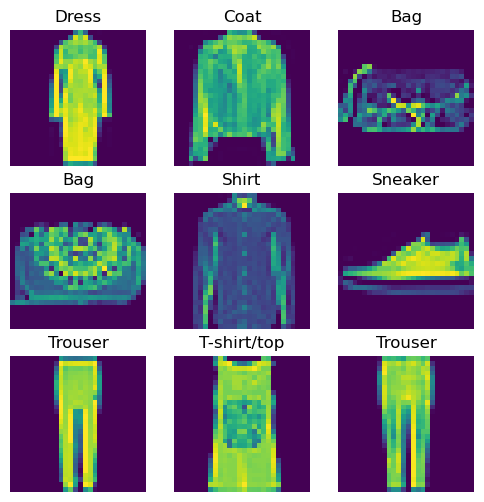

In [207]:
fig = plt.figure(figsize=(6, 6))
for i in range(1, 10):
    idx = torch.randint(0, len(train_data), (1,)).item()
    img, label = train_data[idx]
    fig.add_subplot(3, 3, i)
    plt.imshow(img.squeeze())
    plt.title(train_data.classes[label])
    plt.axis(False)

In [208]:
train_data_loader = DataLoader(train_data, batch_size=32, shuffle=True)

In [192]:
train_data_flatten = torch.empty((1), dtype=torch.int64)
i = 1
for x, _ in train_data_loader:
    flattened = x.flatten()
    train_data_flatten = torch.cat((train_data_flatten, flattened))
train_data_flatten = train_data_flatten[1:].to(device)

In [193]:
class ImageRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0):
        super(ImageRNN, self).__init__()
        self.embedding = nn.Embedding(input_size, input_size)
        self.rnn = nn.RNN(input_size=input_size, 
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          dropout=dropout)
        self.decoder = nn.Linear(in_features=hidden_size,
                                 out_features=output_size)
        
    def forward(self, x, hidden_state):
        embeddings = self.embedding(x)
        output, hidden_state = self.rnn(embeddings, hidden_state)
        output = self.decoder(output)
        return output, hidden_state

In [194]:
ImgRNN = ImageRNN(input_size=256, 
                  hidden_size=512,
                  output_size=256,
                  num_layers=1,
                  dropout=0).to(device)

In [195]:
train(ImgRNN, epochs=5, lr=0.001, device=device, train_data=train_data_flatten)

Training.....


RuntimeError: "nll_loss_forward_reduce_cuda_kernel_2d_index" not implemented for 'Int'